In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
real = pd.read_csv('./dataset/True.csv')
fake = pd.read_csv('./dataset/Fake.csv')

In [3]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
real.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [5]:
real = real.drop(['subject', 'date'], axis=1)
fake = fake.drop(['subject', 'date'], axis=1)

In [29]:
dataset = pd.concat([real.assign(label=1), fake.assign(label=0)])
dataset.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2, random_state=7)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [9]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [10]:
# Training
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
# Testing
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(training_padded.shape)

(35918, 120)


In [12]:
# Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [14]:
# Training
num_epochs = 10
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), verbose=2, callbacks=[checkpoint])

Epoch 1/10



Epoch 1: val_accuracy improved from -inf to 0.98931, saving model to model.h5
1123/1123 - 3s - loss: 0.1831 - accuracy: 0.9502 - val_loss: 0.0358 - val_accuracy: 0.9893 - 3s/epoch - 3ms/step
Epoch 2/10


c:\Users\bonru\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.98931 to 0.99432, saving model to model.h5
1123/1123 - 2s - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.0162 - val_accuracy: 0.9943 - 2s/epoch - 2ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.99432 to 0.99633, saving model to model.h5
1123/1123 - 2s - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.0110 - val_accuracy: 0.9963 - 2s/epoch - 2ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.99633 to 0.99677, saving model to model.h5
1123/1123 - 2s - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0089 - val_accuracy: 0.9968 - 2s/epoch - 2ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.99677
1123/1123 - 2s - loss: 7.9320e-04 - accuracy: 0.9999 - val_loss: 0.0088 - val_accuracy: 0.9968 - 2s/epoch - 2ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.99677 to 0.99710, saving model to model.h5
1123/1123 - 2s - loss: 4.7565e-04 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9971 - 2s/epoch - 2ms/step
Epo

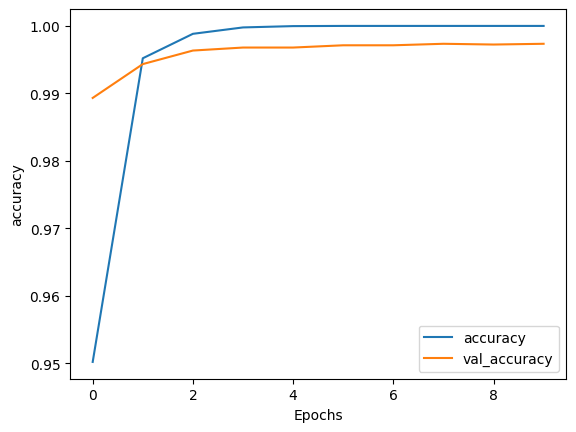

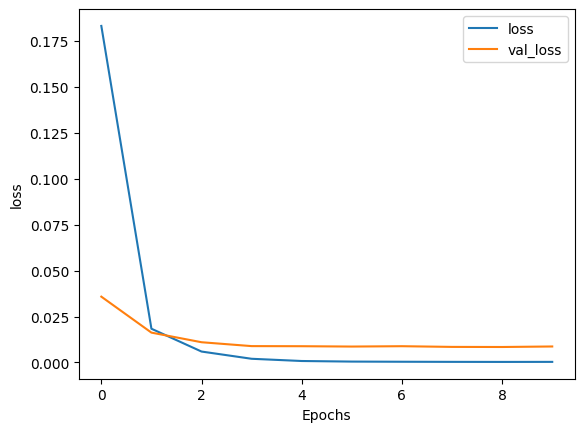

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")